# Create Exoplanet models

In [1]:
import os, sys
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/stella/')
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/scripts/')
import numpy as np
from utils import *
import build_synthetic_set as models
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella
import pandas as pd
import random
import batman
import warnings
from astroquery.mast import Catalogs
import astropy.constants as const
import time as ti
import re
import pickle
import signal

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
files = glob('../data/eleanor/s0007/*.fits', recursive=True)
random.shuffle(files)

In [3]:
folder = '../models/exoplanets1k'
#figs = '../exoplanet-models-figs'

In [4]:
def timeout_handler(signum, frame):
    raise TimeoutError("Timeout reached.")

### Load the star

In [5]:
target_IDs = [int(re.search(r"(\d{16})", filename).group(1).lstrip('0')) for filename in files]

In [6]:
def calculate_timestep(table):
    """
    Function: Calculates the median value of the time differences between data points in a given table. 
    Provides an estimate of the timestep (or time delta) between consecutive data points.

    Parameters:
    :table (array or pandas.DataFrame): The input table containing time-series data.

    Returns:
    :dt (float): The estimated time interval or timestep between consecutive data points."""

    try:
        dt = [ table[i+1][0] - table[i][0] for i in range(len(table)-1) ] # calculates difference between (ith+1) - (ith) point 
        dt.sort()
        return dt[int(len(dt)/2)] # median of them.
    except:
        return np.median(np.diff(table['time'])) ## change this to account for any time column names

    

def clean_data(table):
    """
    Function: Interpolating missing data points, ensuring equal time gaps between points. 
    Returns five numpy arrays: time, flux, quality, real, and flux_error. Real is 0 if data point interpolated, 1 otherwise.

    Parameters:
    :table (astropy.table.table): The input table containing time-series data.
    
    Returns:
    :time (numpy.ndarray): An array of timestamps for each data point, including the interpolated points.
    :flux (numpy.ndarray): An array of flux values for each data point, including the interpolated points.
    :quality (numpy.ndarray): An array indicating the quality of each data point, including the interpolated points.
    :real (numpy.ndarray): An array indicating whether each data point is real (1) or interpolated (0).
    :flux_error (numpy.ndarray): An array of flux error values for each data point, including the interpolated points."""


    time = []
    flux = []
    quality = []
    real = []
    flux_error = []
    timestep = calculate_timestep(table)


    ### this scale factor ensures that you can use any cadence of lightcurves. 48 cadences = 1 day.
    factor = ((1/48)/timestep)

    for row in table:
        ti, fi, qi, fei = row

        if len(time) > 0:
            steps = int(round( (ti - time[-1])/timestep * factor)) # (y2-y1)/(x2-x1)
            if steps > 1:
                fluxstep = (fi - flux[-1])/steps
                fluxerror_step = (fei - flux_error[-1])/steps

                # For small gaps, pretend interpolated data is real.
                if steps > 2:
                    set_real=0
                else:
                    set_real=1

                for _ in range(steps-1):
                    time.append(timestep + time[-1])
                    flux.append(fluxstep + flux[-1])
                    flux_error.append(fluxerror_step + flux_error[-1])

                    quality.append(0)
                    real.append(set_real)
        time.append(ti)
        flux.append(fi)
        quality.append(qi)
        real.append(1)
        flux_error.append(fei)

    return [np.array(x) for x in [time,flux,quality,real,flux_error]]

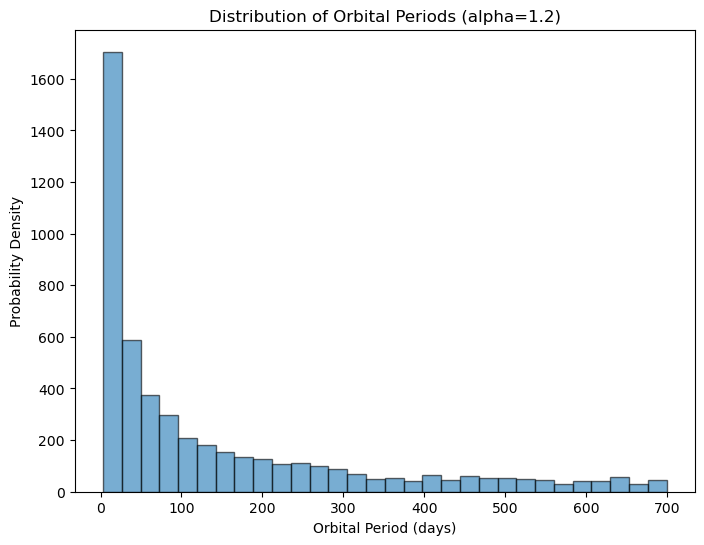

In [7]:
# Define the power law exponent (alpha)
# Larger values of alpha will skew the distribution more towards shorter periods
alpha = 1.2

# Define the minimum and maximum periods
period_min = 3
period_max = 700.0

num_planets = 1
max_retries = 20
retry_delay = 1
timeout_duration = 5

# Generate the orbital periods
periods = []
for _ in range(5000):
    random_value = np.random.uniform(0, 1)
    period = period_min * (period_max / period_min) ** (random_value ** (1 / alpha))
    periods.append(period)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(periods, bins=30,  alpha=0.6, edgecolor='black')
plt.xlabel('Orbital Period (days)')
plt.ylabel('Probability Density')
plt.title(f'Distribution of Orbital Periods (alpha={alpha})')
plt.show()
TIC_table = Catalogs.query_object(f'TIC 270577175', catalog="TIC")
r_star = TIC_table['rad'][0]
m_star = TIC_table['mass'][0]

os.makedirs(folder, exist_ok=True)

# Plot the histogram
# plt.figure(figsize=(8, 6))
# plt.hist(periods, bins=50, edgecolor='black')
# plt.xlabel('Period (days)')

# plt.title('Log Uniform Distribution')
# plt.xlim(period_min, period_max)
# plt.show()

In [8]:
# Constants and parameters
min_snr = 3
max_snr = 20
window_size = 84
max_retries = 20
timeout_duration = 30  # Adjust as needed
retry_delay = 1  # Adjust as needed

times = []
ticid = []
snr = []
p = []
rms_cat = []

for target_ID in tqdm(files[0:1000]):
    try:
        # Read in lightcurve
        lc, lc_info = import_lightcurve(target_ID, drop_bad_points=True)
        sector = f"{lc_info['sector']:02d}"
        tic = lc_info['TIC_ID']

        # Flatten the original lightcurve
        flat_flux = wotan.flatten(lc['TIME'], lc['PCA_FLUX'], method='median', window_length=1)

        # Get RMS of flattened original lightcurve
        rms = np.nanstd(flat_flux)
        if np.isnan(rms):
            continue

        # Identify large gaps in original lightcurve
        diff = np.diff(lc['TIME'])
        large_gaps_indices = np.where(diff > 1)[0]

        # Create copy of lightcurve and clean data
        lcc = lc.copy()
        lcc = lcc[lcc['QUALITY'] == 0]
        lcc = lcc['TIME', 'PCA_FLUX', 'QUALITY', 'FLUX_ERR']
        time, flux, quality, real, flux_error = clean_data(lcc)

        # Choose random SNR value and calculate amplitude
        random_snr = np.random.uniform(min_snr, max_snr)
        A = rms * random_snr

        valid_model_found = False
        retry_count = 0

        while not valid_model_found and retry_count < max_retries:
            signal.signal(signal.SIGALRM, timeout_handler)
            signal.alarm(timeout_duration)

            try:
                # Find valid injection time
                valid_time_found = False
                while not valid_time_found:
                    t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])
                    
                    # Check if t0 avoids large gaps
                    valid_t0 = True
                    for index in large_gaps_indices:
                        start_time = lc['TIME'][index] - 1
                        end_time = lc['TIME'][index + 1] + 1
                        if start_time <= t0 <= end_time:
                            valid_t0 = False
                            break
                        elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 1.5:
                            valid_t0 = False
                            break
                        elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 1.5:
                            valid_t0 = False
                            break
                        elif t0 <= lc['TIME'][0] + 2 or t0 >= lc['TIME'][-1] - 2:
                            valid_t0 = False
                            break

                    if valid_t0:
                        # Check if all data points within the window are non-interpolated
                        window_start = np.argmin(np.abs(time - (t0 - window_size * np.median(np.diff(time)))))
                        window_end = np.argmin(np.abs(time - (t0 + window_size * np.median(np.diff(time))))) + 1
                        if np.all(real[window_start:window_end] == 1):
                            valid_time_found = True

                # Create transit model
                params = batman.TransitParams()
                params.t0 = t0
                random_value = np.random.uniform(0, 1)
                params.per = period_min * (period_max / period_min) ** (random_value ** (1 / alpha))
                p.append(params.per)
                params.rp = np.sqrt(A)
                params.a = ((params.per * 86400.) ** 2 * const.G.value * m_star * const.M_sun.value / 
                            (4 * np.pi**2)) ** (1/3) / (r_star * const.R_sun.value)
                params.inc = 90
                params.ecc = 0
                params.w = 90
                params.limb_dark = "linear"
                params.u = [np.random.uniform(0.2, 0.8)]  # Linear limb darkening coefficient

                m = batman.TransitModel(params, time, fac=0.02)
                model = m.light_curve(params)

                # Inject model into lightcurve
                injected_flux = model * (flux / np.nanmedian(flux))

                if np.all(injected_flux >= 0):
                    valid_model_found = True
                else:
                    retry_count += 1

            except TimeoutError:
                retry_count += 1
            except Exception as e:
                if "Convergence failure" in str(e):
                    retry_count += 1
                else:
                    raise e
            finally:
                signal.alarm(0)

        if not valid_model_found:
            print(f"Failed to create a valid model for file {target_ID} after {max_retries} attempts. Skipping...")
            continue

        # Save injected lightcurve
        fluxerror = flux_error / np.nanmedian(flux)
        np.save(f"{folder}/{tic}_sector{sector}.npy", 
                np.array([time[real == 1], injected_flux[real == 1], fluxerror[real == 1], real[real == 1], model[real == 1]]))

        # Update catalogs
        times.append(t0)
        ticid.append(tic)
        snr.append(random_snr)
        rms_cat.append(rms)

    except Exception as e:
        print(f"Exception occurred for file {target_ID}: {e}. Continuing...")
        continue

 68%|█████████████████████████████████████████▏                   | 675/1000 [00:23<00:10, 29.67it/s]

Failed to create a valid model for file ../data/eleanor/s0007/hlsp_gsfc-eleanor-lite_tess_ffi_s0007-0000000014499040_tess_v1.0_lc.fits after 20 attempts. Skipping...


100%|████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.76it/s]


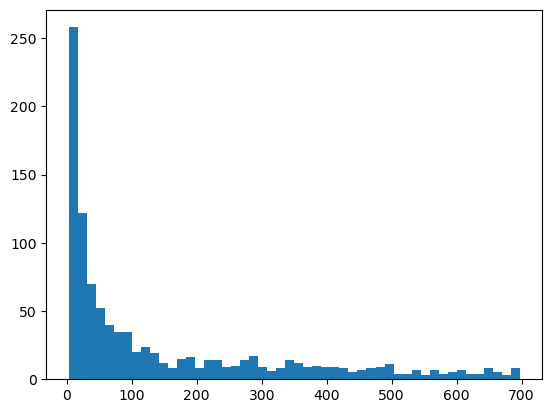

In [9]:
plt.hist(p,bins=50)
plt.show()

In [10]:
data = pd.DataFrame(data=[ticid,times]).T
data.columns = ['TIC','tpeak']
data.TIC = data.TIC.astype(int)
table = Table.from_pandas(data)

table.write('../catalogs/exoplanets1k.txt', format='ascii', overwrite=True) 

In [11]:
ds = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/models/exoplanets1k/',
                         catalog='/Users/azib/Documents/open_source/nets2/catalogs/exoplanets1k.txt',cadences=168,training=0.8,merge_datasets=False,frac_balance=0.7)

Reading in training set files.


100%|████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1865.80it/s]


999 positive classes
924 negative classes
108.0% class imbalance

unique labels: [0 1]


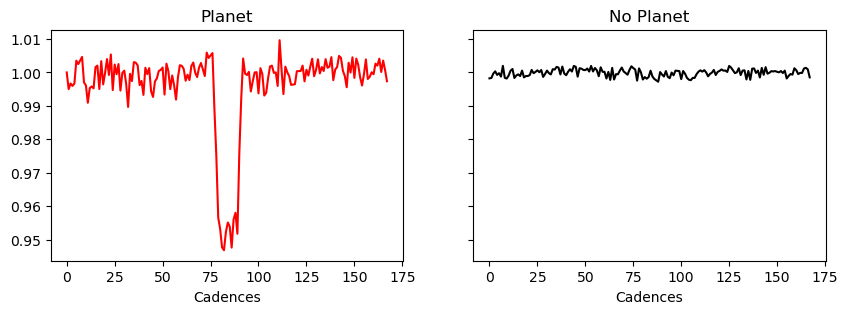

In [12]:
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[0]], 'r')
ax1.set_title('Planet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[0]], 'k')
ax2.set_title('No Planet')
ax2.set_xlabel('Cadences');

In [13]:
os.makedirs('exoplanet-models/',exist_ok=True)
dsmodels = ds.train_data[ind_pc]
num_sets = dsmodels.shape[0] // 100

for set_index in tqdm(range(num_sets)):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    plt.savefig(f'exoplanet-models/exoplanet-models-{start_index}-{end_index}.png',dpi=200)
    plt.close()  
    

100%|██████████████████████████████████████████████████████████████████| 8/8 [01:20<00:00, 10.06s/it]


In [14]:
np.where(ds.train_data < 0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

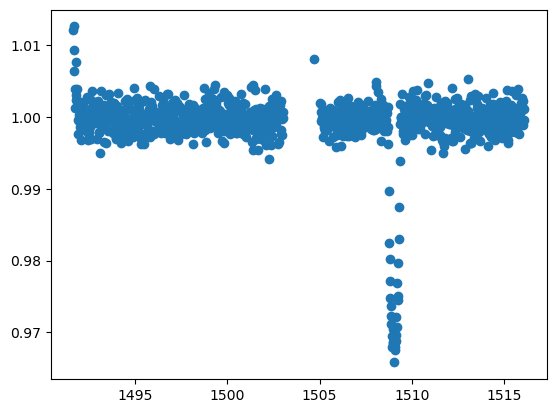

In [19]:
a = np.load('../exoplanet-models/264869145_sector07-exoplanet.npy')
plt.scatter(a[0],a[1])
#plt.scatter(a[0][a[3] == 1],a[1][a[3] == 1])
